# Intelligent Interactive Systems - Final project

Roy Bros<br>
Geva Benori

# Table of contents

On the first section, we will explain how an audio proccess goes.<br>
Afterwards, we will start our full audio proccess over all data to generate features for our deep learning model.<br>
The third section will be the test over our trainned model, showing our results.<br>
To summarize: <br>
Section 1: study case of audio proccess <br>
Section 2: building and training a deep learning model over our full dataset <br>
Section 3: testing our model and showing results <br>

## Imports

In [1]:
#audio analysis
import librosa

#displaying
import IPython.display as ipd
import librosa.display

#visualization
import matplotlib.pyplot as plt

import pandas as pd
import scipy as sp
import numpy as np
from tqdm import tqdm

## Section 1 - Audio proccess

Loading example audio file

In [2]:
BASE_PATH = r"C:\Users\gevab\OneDrive\שולחן העבודה\לימודים\סמסטר ז'\מערכות נבונות אינטראקטיביות\פרויקט\UrbanSound8K\UrbanSound8K"

In [3]:
audio_path = BASE_PATH + r'\audio'+ r'\fold' + r"5" + r"\100263-2-0-117.wav"
audio_data, sample_rate = librosa.load(audio_path)

In [4]:
print(f"The example audio file sample rate is {sample_rate} (samples/second)")

The example audio file sample rate is 22050 (samples/second)


In [5]:
print("Example slice of the audio file:\n", audio_data[22500:22550])

Example slice of the audio file:
 [-7.5498149e-03 -5.4645804e-03 -1.9243360e-03  2.1837297e-04
 -1.7908252e-03 -5.7274639e-03 -7.7999332e-03 -7.4513908e-03
 -5.1562060e-03 -3.9896402e-03 -3.9120032e-03 -3.9812601e-03
 -4.2541400e-03 -4.7458922e-03 -5.9568975e-03 -6.3649667e-03
 -4.7563412e-03 -1.9171966e-03  1.4202707e-03  2.4926129e-03
  4.6705673e-04 -1.1300227e-03 -2.3746158e-03 -3.0362268e-03
 -3.0602589e-03 -3.7072105e-03 -2.9997395e-03 -3.5995659e-03
 -4.5606443e-03 -4.8101256e-03 -5.7348404e-03 -4.2612436e-03
 -3.1097496e-03 -3.1233134e-03 -5.1122266e-03 -7.1401810e-03
 -7.0324782e-03 -6.7165443e-03 -6.7237145e-03 -7.8253513e-03
 -7.9476209e-03 -5.3283651e-03 -2.0960721e-03  5.8989268e-04
  5.4069293e-05 -2.3825264e-03 -4.0889843e-03 -6.6695954e-03
 -7.7475384e-03 -7.5550210e-03]


In [6]:
ipd.Audio(audio_path)

Audio visualization

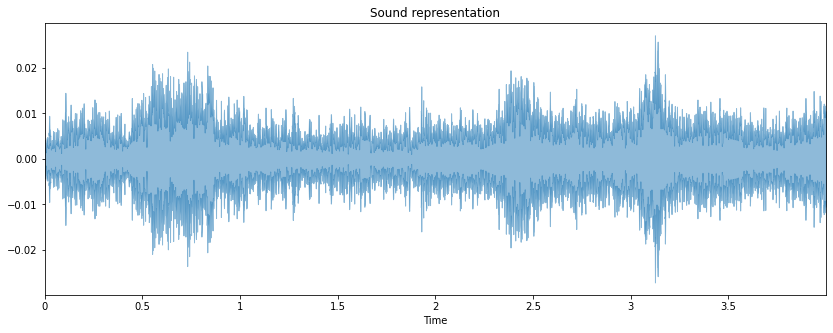

In [7]:
plt.figure(figsize=(14,5))
plt.title("Sound representation")
librosa.display.waveplot(audio_data, sr=sample_rate, alpha=0.5)
plt.show()

Applying fast Fourier transform to get representation in frequency domain

In [8]:
ft = sp.fft.fft(audio_data)
magnitude = np.absolute(ft)
frequency = np.linspace(0, sample_rate, len(magnitude)) 

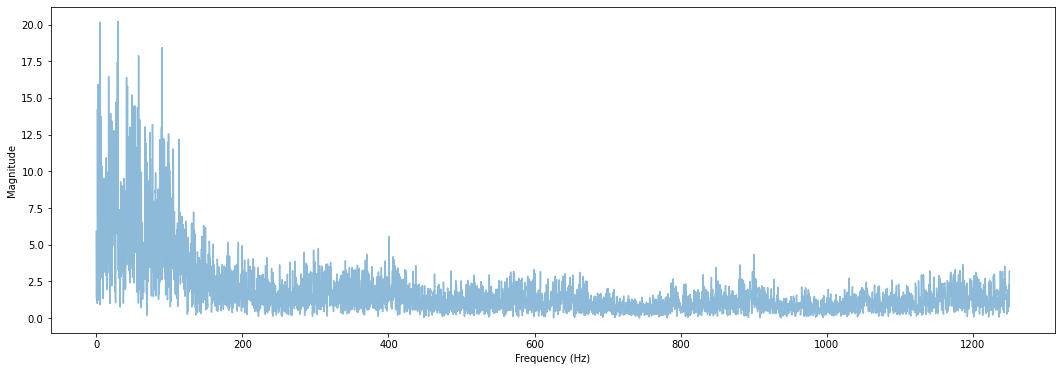

In [9]:
plt.figure(figsize=(18, 6))
plt.plot(frequency[:5000], magnitude[:5000] ,alpha=0.5) # magnitude spectrum
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

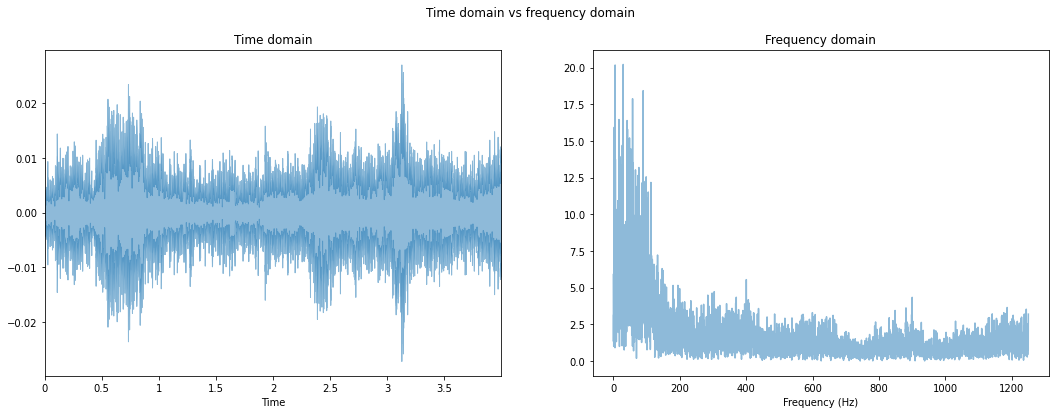

In [10]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plt.suptitle("Time domain vs frequency domain")
librosa.display.waveplot(audio_data, sr=sample_rate, alpha=0.5, ax=axis[0])
axis[1].plot(frequency[:5000], magnitude[:5000], alpha=0.5)

axis[0].set(title='Time domain')
axis[1].set(title='Frequency domain', xlabel="Frequency (Hz)")
plt.show()

### Feature Extracting

Extracting features for the model from mel cepstrum

In [11]:
mfccs = librosa.feature.mfcc(y=audio_data, n_mfcc=13, sr=sample_rate)

In [12]:
mfccs.shape

(13, 173)

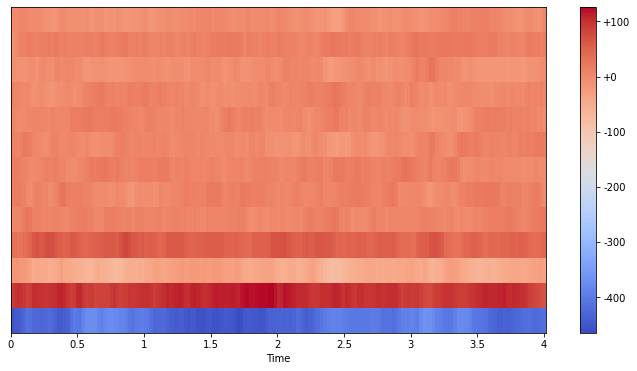

In [13]:
plt.figure(figsize=(12, 6))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sample_rate)
plt.colorbar(format="%+2.f")
plt.show()

Each row in the above plot, represents a coefficient which is the presence of a specific range of frequencies across time.<br>
In order to get a fixed number of parameters for each audio (without the dependency of time), we will calculate their mean.<br>
We will call each means the centroid of the bucket.

In [14]:
mfccs_mean_features = np.mean(mfccs, axis=1)
mfccs_mean_features

array([-417.29105  ,  100.148506 ,  -43.869255 ,   51.953114 ,
          9.044406 ,    8.780207 ,   10.375921 ,    2.7313879,
          6.175258 ,    5.0651426,   -4.3706613,   14.675569 ,
         -3.529977 ], dtype=float32)

# Section 2 - Building and taining deep learning model

#### Hyperparameters

In [15]:
n_mfcc = 50
drop_out_prob = 0.5

In [16]:
meta_data_df = pd.read_csv(BASE_PATH + r'\metadata\UrbanSound8K.csv')
meta_data_df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [17]:
#checking the amount of samples we have per class
meta_data_df['class'].value_counts()

engine_idling       1000
jackhammer          1000
children_playing    1000
street_music        1000
dog_bark            1000
air_conditioner     1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [18]:
def features_extractor(file_path ,n_mfcc=13):
    """compute the MFCC coefficients for a given audio file, and mean over each mel coefficients over time"""
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_scaled_features = np.mean(mfccs_features, axis=1)
    return mfccs_scaled_features

In [19]:
def create_features_dataset(n_mfcc=13):
    extracted_features_list = []
    for i, row in tqdm(meta_data_df.iterrows()):
        file_full_path = BASE_PATH + r'\audio'+ r'\fold' + str(row["fold"]) + '\\' + str(row["slice_file_name"])
        file_class = row["class"]
        file_features = features_extractor(file_full_path, n_mfcc=n_mfcc)

        extracted_features_list.append([file_features, file_class])

    data_df = pd.DataFrame(extracted_features_list, columns=[f'MFCC_{n_mfcc}', 'label'])
    return data_df

In [367]:
data_df = create_features_dataset(n_mfcc=n_mfcc)
data_df.head()

3555it [03:20, 19.72it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8325it [08:07, 21.60it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [08:31, 17.06it/s]


,MFCC_50,label
0,"[-215.79301, 71.66612, -131.81377, -52.091328,...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01074, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265694,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.608585, 1....",children_playing


In [371]:
X = np.array(data_df[f'MFCC_{n_mfcc}'].tolist())
y = np.array(data_df['label'].tolist())

In [369]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))
y

In [ ]:
print(f"y.shape: {y.shape}, X.shape: {X.shape}")

In [373]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [377]:
num_labels = y.shape[1]

In [378]:
model = Sequential()

#first layer
model.add(Dense(100, input_shape=(n_mfcc,)))
model.add(Activation('relu'))
model.add(Dropout(drop_out_prob))

#second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(drop_out_prob))

#third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(drop_out_prob))

#final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [379]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 100)               5100      
                                                                 
 activation_42 (Activation)  (None, 100)               0         
                                                                 
 dropout_30 (Dropout)        (None, 100)               0         
                                                                 
 dense_43 (Dense)            (None, 200)               20200     
                                                                 
 activation_43 (Activation)  (None, 200)               0         
                                                                 
 dropout_31 (Dropout)        (None, 200)               0         
                                                                 
 dense_44 (Dense)            (None, 100)             

In [380]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [381]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 1000
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification2.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/1000
216/219 [============================>.] - ETA: 0s - loss: 10.2856 - accuracy: 0.1225
Epoch 1: val_loss improved from inf to 2.28414, saving model to saved_models\audio_classification2.hdf5
219/219 [==============================] - 1s 3ms/step - loss: 10.2126 - accuracy: 0.1223 - val_loss: 2.2841 - val_accuracy: 0.1116
Epoch 2/1000
191/219 [=========================>....] - ETA: 0s - loss: 2.5339 - accuracy: 0.1216
Epoch 2: val_loss improved from 2.28414 to 2.26738, saving model to saved_models\audio_classification2.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 2.5174 - accuracy: 0.1204 - val_loss: 2.2674 - val_accuracy: 0.1196
Epoch 3/1000
196/219 [=========================>....] - ETA: 0s - loss: 2.3108 - accuracy: 0.1341
Epoch 3: val_loss improved from 2.26738 to 2.20052, saving model to saved_models\audio_classification2.hdf5
219/219 [==============================] - 1s 2ms/step - loss: 2.3080 - accuracy: 0.1382 - val_loss: 2.2005 - val_accuracy

KeyboardInterrupt: 

In [382]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

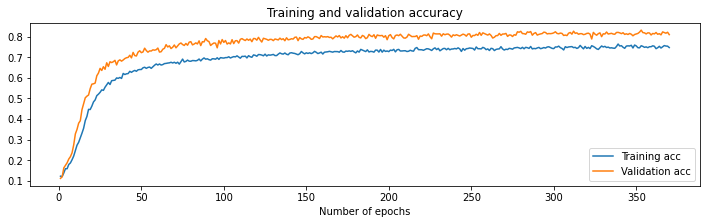

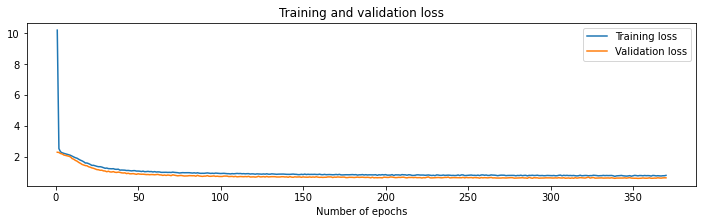

In [383]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(12, 3))
plt.plot(epochs, acc, '-', label='Training acc')
plt.plot(epochs, val_acc, '-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Number of epochs')
plt.legend()

plt.figure(figsize=(12, 3))
plt.plot(epochs, loss, '-', label='Training loss')
plt.plot(epochs, val_loss, '-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.legend()

plt.show()

________________________

## Baseline models

### RandomForestClassifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=20)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("RandomForestClassifier Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6508299942759015


### KNeighborsClassifier

In [374]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("KNeighborsClassifier Accuracy:", metrics.accuracy_score(y_test, y_pred))

KNeighborsClassifier Accuracy: 0.8586147681740126


### SVM

In [31]:
from sklearn import svm

y_train_svm = list(map(lambda row: list(row).index(1), y_train))

clf = svm.SVC(C=15, kernel='rbf')
clf.fit(X_train, y_train_svm)

y_pred = clf.predict(X_test)
y_test_svm = list(map(lambda row: list(row).index(1), y_test))

print("SVM Accuracy:", metrics.accuracy_score(y_test_svm, y_pred))

Accuracy: 0.748712077847739


# Testing differnct n_mfcc values

In [20]:
acc_per_n_mfcc_dict = {}
n_mfcc_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]

In [ ]:
for n in n_mfcc_values:
    
    data_n_mfcc = create_features_dataset(n_mfcc = n)
    X = np.array(data_n_mfcc[f'MFCC_{n}'].tolist())
    y = np.array(data_n_mfcc['label'].tolist())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc_per_n_mfcc_dict[n] = metrics.accuracy_score(y_test, y_pred)
    print(f'n={n}:', metrics.accuracy_score(y_test, y_pred))

8732it [07:30, 19.37it/s]
3it [00:00, 29.69it/s]

n=5: 0.7195191757298226


3555it [04:06, 12.00it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8325it [08:20, 20.59it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [08:39, 16.81it/s]
3it [00:00, 21.19it/s]

n=10: 0.8242701774470521


3553it [03:04, 21.35it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8325it [06:55, 27.15it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [07:14, 20.11it/s]
3it [00:00, 26.79it/s]

n=15: 0.8448769318832284


3554it [02:57, 21.82it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8326it [06:33, 27.82it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [06:51, 21.22it/s]
3it [00:00, 27.77it/s]

n=20: 0.8483113909559244


3553it [02:47, 21.52it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8323it [06:21, 27.45it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
8328it [06:21, 31.44it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [06:38, 21.89it/s]
3it [00:00, 27.35it/s]

n=25: 0.8540354894104178


3554it [02:47, 21.97it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8324it [08:02, 13.06it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
8329it [08:02, 16.37it/s]C:\Users\gevab\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [08:42, 16.72it/s]
0it [00:00, ?it/s]

n=30: 0.8586147681740126


1061it [02:07,  4.03it/s]

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.lineplot(x=list(acc_per_n_mfcc_dict.keys()), y=list(acc_per_n_mfcc_dict.values()))
plt.title("Model acc vs number of mfcc coefficients")
plt.xlabel("Number of mfcc coefficients")
plt.ylabel("Accuracy")
plt.grid(alpha=0.5)
plt.show()

As we can see, more coefficients increase the model accuracy, up to a certain point (around 50 coefficients).

# MNIST DataSet

Now that we have checked the best number of coefficients to extract from an audio file, we will test our findings with another dataset.

In [395]:
from os import listdir
from os.path import isfile, join

MNIST_BASE_PATH = r'C:\Users\gevab\PycharmProjects\AudioMNIST\data'

In [208]:
MINST_extracted_features_list = []
MINST_n_mfcc = 50

number_of_folder = 60
for floder_num in tqdm(range(1, number_of_folder+1)):
    folder_name = str(floder_num).zfill(2)
    folder_path = MNIST_BASE_PATH + f'\\{folder_name}'
    list_of_file = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    
    for file in list_of_file:
        file_features = features_extractor(folder_path + '\\' + file, n_mfcc=MINST_n_mfcc)
        MINST_extracted_features_list.append([file_features, file[0]])
    
            

MNIST_data_df = pd.DataFrame(MINST_extracted_features_list, columns=[f'MFCC_{MINST_n_mfcc}', 'label'])
MNIST_data_df.head()

100%|██████████| 60/60 [06:41<00:00,  6.69s/it]


,MFCC_13,label
0,"[-625.6628, 108.88213, 1.3060446, 35.152134, 1...",0
1,"[-642.4038, 113.41726, 9.338126, 42.384674, 23...",0
2,"[-607.6836, 108.46689, -5.146829, 29.399002, 1...",0
3,"[-596.3106, 118.99427, -5.5381374, 29.014175, ...",0
4,"[-625.29755, 106.505165, 10.876012, 35.871765,...",0


In [402]:
MNIST_data_df['label'].value_counts().reset_index(name='amount').rename(columns={'index':'digit label'}).sort_values(by='digit label')

,digit label,amount
2,0,3000
5,1,3000
8,2,3000
7,3,3000
3,4,3000
1,5,3000
6,6,3000
9,7,3000
0,8,3000
4,9,3000


In [407]:
MNIST_data_df.columns = [f'MFCC_{MINST_n_mfcc}', 'label']

X = np.array(MNIST_data_df[f'MFCC_{MINST_n_mfcc}'].tolist())
y = np.array(MNIST_data_df['label'].astype(int).tolist())

In [408]:
labelencoder = LabelEncoder()

y = to_categorical(labelencoder.fit_transform(y))

In [410]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [411]:
y_train_knn = list(map(lambda x: list(x).index(1), y_train))
y_test_knn = list(map(lambda x: list(x).index(1), y_test))

## KNeighborsClassifier over MNIST

In [412]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train_knn)

y_pred = clf.predict(X_test)

print("KNeighborsClassifier Accuracy:", metrics.accuracy_score(y_test_knn, y_pred))

KNeighborsClassifier Accuracy: 0.9821666666666666


As we can see, the KNN model works pretty well over another dataset, we will now check the performance of the neural network to see if KNN still makes better results.

## Fully connected neural network

In [424]:
NMIST_drop_out_prob = 0.2

num_labels = y.shape[1]

model = Sequential()

#first layer
model.add(Dense(100, input_shape=(MINST_n_mfcc,)))
model.add(Activation('relu'))
model.add(Dropout(NMIST_drop_out_prob))

#second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(NMIST_drop_out_prob))

#third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(NMIST_drop_out_prob))

#final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [425]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [426]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification_MNIST.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
747/750 [============================>.] - ETA: 0s - loss: 3.5861 - accuracy: 0.1018
Epoch 1: val_loss improved from inf to 2.30272, saving model to saved_models\audio_classification_MNIST.hdf5
750/750 [==============================] - 2s 2ms/step - loss: 3.5809 - accuracy: 0.1018 - val_loss: 2.3027 - val_accuracy: 0.0977
Epoch 2/200
724/750 [===========================>..] - ETA: 0s - loss: 2.3069 - accuracy: 0.0985
Epoch 2: val_loss improved from 2.30272 to 2.30268, saving model to saved_models\audio_classification_MNIST.hdf5
750/750 [==============================] - 1s 2ms/step - loss: 2.3068 - accuracy: 0.0986 - val_loss: 2.3027 - val_accuracy: 0.0970
Epoch 3/200
731/750 [============================>.] - ETA: 0s - loss: 2.3047 - accuracy: 0.0985
Epoch 3: val_loss improved from 2.30268 to 2.30266, saving model to saved_models\audio_classification_MNIST.hdf5
750/750 [==============================] - 1s 2ms/step - loss: 2.3048 - accuracy: 0.0983 - val_loss: 2.3027 - va

In [224]:
NMIST_acc = model.history.history['accuracy']
NMIST_val_acc = model.history.history['val_accuracy']
NMIST_loss = model.history.history['loss']
NMIST_val_loss = model.history.history['val_loss']

In [240]:
print("Fully connected neural network Accuracy:", NMIST_val_acc[-1])

Fully connected neural network Accuracy: 0.9748333096504211


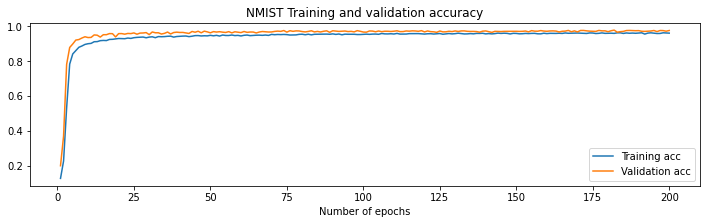

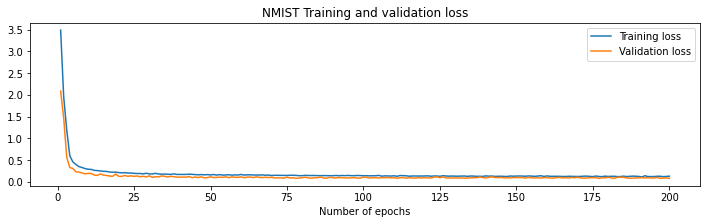

In [225]:
import matplotlib.pyplot as plt

epochs = range(1, len(NMIST_acc) + 1)
plt.figure(figsize=(12, 3))
plt.plot(epochs, NMIST_acc, '-', label='Training acc')
plt.plot(epochs, NMIST_val_acc, '-', label='Validation acc')
plt.title('NMIST Training and validation accuracy')
plt.xlabel('Number of epochs')
plt.legend()

plt.figure(figsize=(12, 3))
plt.plot(epochs, NMIST_loss, '-', label='Training loss')
plt.plot(epochs, NMIST_val_loss, '-', label='Validation loss')
plt.title('NMIST Training and validation loss')
plt.xlabel('Number of epochs')
plt.legend()

plt.show()

# Testing our own sempales

In [415]:
def compare_predicrtions(knn, nn_model, file_path, n_mfcc=50):
    features_data = features_extractor(file_path, n_mfcc=n_mfcc)
    features_data = features_data.reshape(1, -1)
    
    knn_predict_class = knn.predict(features_data)
    nn_model_predict_class = np.argmax(nn_model.predict(features_data))
   
    return f"KNN class: {knn_predict_class[0]}, nn model calss: {nn_model_predict_class}"

We will now show specific 3 samples of our own:

In [421]:
RECORDE_ONE_PATH = r'C:\Users\gevab\Downloads\one_record.wav'
res = compare_predicrtions(clf, model, RECORDE_ONE_PATH)
print(res)
ipd.Audio(RECORDE_ONE_PATH)

KNN class: 0, nn model calss: 3


In [422]:
RECORDE_ONEV2_PATH = r'C:\Users\gevab\Downloads\11.wav'
res = compare_predicrtions(clf, model, RECORDE_ONEV2_PATH)
print(res)
ipd.Audio(RECORDE_ONEV2_PATH)

KNN class: 1, nn model calss: 8


In [423]:
ZERO_ONE_PATH = r'C:\Users\gevab\Downloads\zero_record.wav'
res = compare_predicrtions(clf, model, ZERO_ONE_PATH)
print(res)
ipd.Audio(ZERO_ONE_PATH)

KNN class: 5, nn model calss: 3


Seeing that for our own testing the accuracy is not as consistent as the test data set.<br>
Now, we will check a few more tests on our own to check the following hypothesis:<br>
The data on which we trained is not as varied as it should have been. we think that the fact that the same person has made all the records is the reason for it. Hence the model is very good for his predictions, but not for outsourcing voices.

In [428]:
upper_path = r"C:\Users\gevab\OneDrive\שולחן העבודה\לימודים\סמסטר ז'\מערכות נבונות אינטראקטיביות\פרויקט\הגשה סופית\ounTests"

listdir(upper_path)

['00.wav',
 '1.wav',
 '11.wav',
 '7.wav',
 'five_record.wav',
 'nine_record.wav',
 'one_record.wav',
 'seven_record.wav',
 'zero_record.wav']

In [430]:
upper_path = r"C:\Users\gevab\OneDrive\שולחן העבודה\לימודים\סמסטר ז'\מערכות נבונות אינטראקטיביות\פרויקט\הגשה סופית\ounTests"
for record in listdir(upper_path):
    full_path = upper_path + '\\' + record
    res = compare_predicrtions(clf, model, full_path)
    print(record, res)

00.wav KNN class: 5, nn model calss: 9
1.wav KNN class: 9, nn model calss: 1
11.wav KNN class: 1, nn model calss: 1
7.wav KNN class: 5, nn model calss: 9
five_record.wav KNN class: 5, nn model calss: 9
nine_record.wav KNN class: 5, nn model calss: 9
one_record.wav KNN class: 0, nn model calss: 1
seven_record.wav KNN class: 7, nn model calss: 9
zero_record.wav KNN class: 5, nn model calss: 1
